In [50]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [37]:
home_path = os.path.expanduser("~")
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text.csv'
df = pd.read_csv(fp)

In [38]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [39]:
print(f'Number of documents in dataset: {len(df)}')

Number of documents in dataset: 2225


There are 5 classes in the dataset

In [40]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

The number of examples in each class is:

In [41]:
df.groupby('category').count()

,text
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


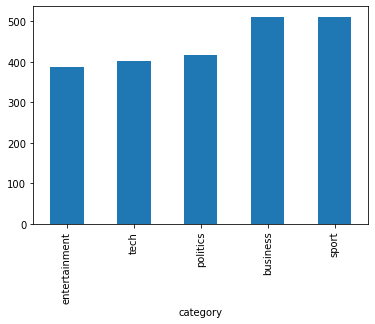

In [43]:
df.groupby('category').size().sort_values().plot.bar();

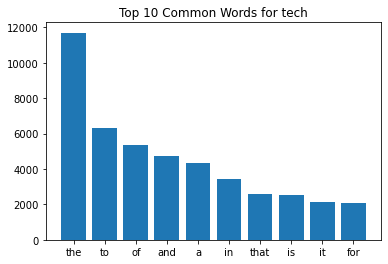

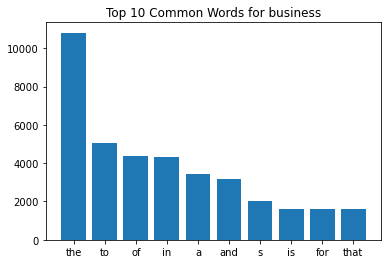

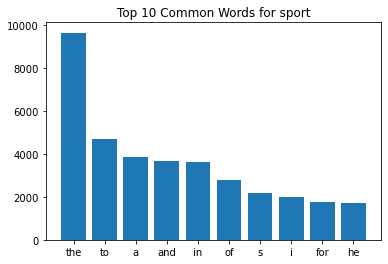

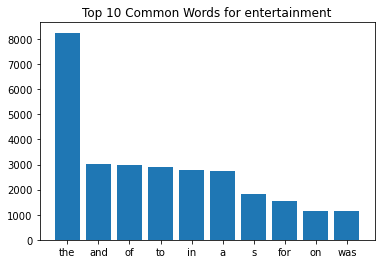

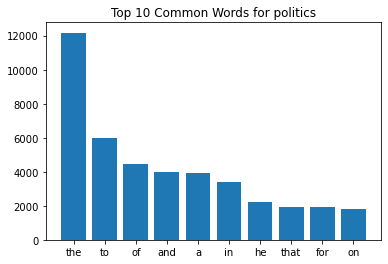

In [97]:
def plot_common_words(text, category):
    text_dict = dict(text)
    plt.bar(text_dict.keys(), text_dict.values())
    plt.title(f'Top 10 Common Words for {category}')
    plt.show()
    
for category in df.category.unique():
    text = ' '.join(categories.get_group(category)['text'])
    common_words = Counter(text.split()).most_common(10)
    plot_common_words(common_words, category)

Plot wordcloud from the first row of text in the dataframe

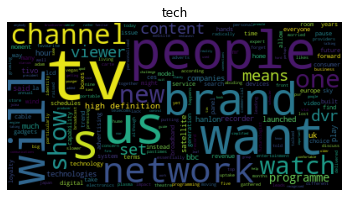

In [66]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

text = df.text[0]
category = df.category[0]
plot_wordcloud(text, category)

What about word clouds for all the text in each category

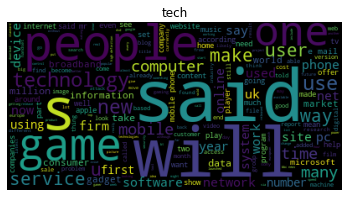

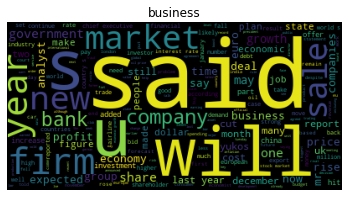

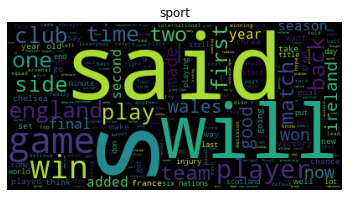

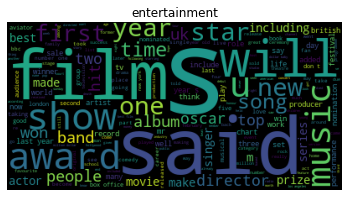

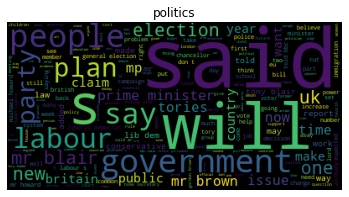

In [68]:
for category in df.category.unique():
    text = ' '.join(categories.get_group(category)['text'])
    plot_wordcloud(text, category)

Looks like said and will come up very often in all categories.

These are words we will want to remove.